In [1]:
from slsim.cluster_lens import ClusterLens
from slsim.lens_pop import LensPop

from astropy.cosmology import FlatLambdaCDM

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.units import Quantity
import copy

In [2]:
np.random.seed(1)

In [3]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_type="elliptical",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [4]:
source_dict = gg_lens_pop._sources.draw_source()

In [5]:
deflector_dict = dict(
    z = 0.4,
    vel_disp = 400.,
    e1_light = 0.0,
    e2_light = 0.0,
    e1_mass = 0.1,
    e2_mass = -0.05,
)

In [6]:
n_subhaloes = 10
z_tolerance = 0.05
n_try = 1000

i = 0
subhaloes_table = []
while (i < n_try) and len(subhaloes_table) < n_subhaloes:
    subhalo = gg_lens_pop._lens_galaxies.draw_deflector()
    if np.abs(subhalo['z'] - deflector_dict['z']) < z_tolerance:
        subhaloes_table.append(subhalo)
subhaloes_table = vstack(subhaloes_table)
subhaloes_table["center_x_mass"] = np.random.normal(0., 5., n_subhaloes)
subhaloes_table["center_y_mass"] = np.random.normal(0., 5., n_subhaloes)
subhaloes_table["center_x_light"] = subhaloes_table["center_x_mass"]
subhaloes_table["center_y_light"] = subhaloes_table["center_y_mass"]
len(subhaloes_table)

10

In [7]:
cluster_lens = ClusterLens(source_dict, deflector_dict, subhaloes_table, cosmo)

In [8]:
lenstronomy_components, lenstronomy_kwargs = cluster_lens.lenstronomy_kwargs(band='g')

In [9]:
lenstronomy_kwargs['kwargs_lens'][0]['theta_E']

3.040297602748879

In [10]:
lenstronomy_kwargs['kwargs_source'][0]['center_x'] = 0.0
lenstronomy_kwargs['kwargs_source'][0]['center_y'] = 0.0

In [11]:
# Instrument setting from pre-defined configurations
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Plots import plot_util

from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

DES_g = DES(band='g', psf_type='GAUSSIAN', coadd_years=3)
DES_r = DES(band='r', psf_type='GAUSSIAN', coadd_years=3)
DES_i = DES(band='i', psf_type='GAUSSIAN', coadd_years=3)
des = [DES_g, DES_r, DES_i]

LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)
lsst = [LSST_g, LSST_r, LSST_i]

Roman_g = Roman(band='F062', psf_type='PIXEL', survey_mode='wide_area')
Roman_r = Roman(band='F106', psf_type='PIXEL', survey_mode='wide_area')
Roman_i = Roman(band='F184', psf_type='PIXEL', survey_mode='wide_area')
roman = [Roman_g, Roman_r, Roman_i]



In [12]:
kwargs_model = {'lens_model_list': lenstronomy_components["lens_model_list"],  # list of lens models to be used
                'lens_light_model_list': lenstronomy_components["lens_light_model_list"],  # list of unlensed light models to be used
                'source_light_model_list': lenstronomy_components["source_light_model_list"],  # list of extended source models to be used, here we used the interpolated real galaxy
    }

In [13]:
# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lenstronomy_components["lens_model_list"])

In [14]:
# import the LightModel class #
from lenstronomy.LightModel.light_model import LightModel
# set up the list of light models to be used #
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=lenstronomy_components["source_light_model_list"])
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lenstronomy_components["lens_light_model_list"])

In [15]:
# import the PixelGrid() class #
from lenstronomy.Data.pixel_grid import PixelGrid
deltaPix = 0.05  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.1,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

In [16]:
kwargs_source_mag_g = lenstronomy_kwargs["kwargs_source"]
kwargs_lens_light_mag_g = lenstronomy_kwargs["kwargs_lens_light"]


# and now we define the colors of the other two bands

# r-band
g_r_source = -1  # color mag_g - mag_r for source
g_r_lens = 1  # color mag_g - mag_r for lens light
g_r_ps = 0
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_r[i]['magnitude'] -= g_r_lens

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]['magnitude'] -= g_r_source

# i-band
g_i_source = -2
g_i_lens = 2
g_i_ps = 0
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_i[i]['magnitude'] -= g_i_lens

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]['magnitude'] -= g_i_source

In [17]:
from astropy.visualization import ZScaleInterval

def make_zscale_rgb(r, g, b, mask=None, **kwargs):
    if mask is None:
        mask = np.ones(r.shape, dtype=bool)
    zscale = ZScaleInterval(**kwargs)
    rmin, rmax = zscale.get_limits(r[mask])
    gmin, gmax = zscale.get_limits(g[mask])
    bmin, bmax = zscale.get_limits(b[mask])
    rgb = np.dstack(((r - rmin)/(rmax - rmin),
                     (g - gmin)/(gmax - gmin),
                     (b - bmin)/(bmax - bmin),
                     mask.astype(float)))
    rgb = np.clip(rgb, 0, 1)
    rgb = (rgb * 255.999).astype(np.uint8)
    return rgb

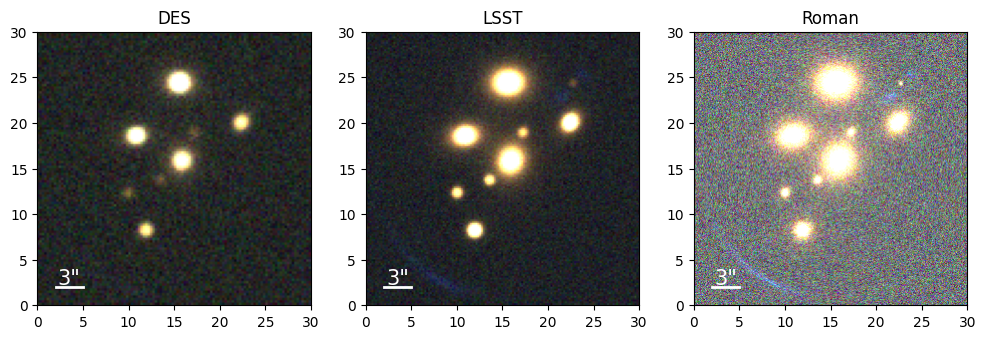

In [18]:
numpix = 200  # number of pixels per axis of the image to be modelled

# here we define the numerical options used in the ImSim module. 
# Have a look at the ImageNumerics class for detailed descriptions.
# If not further specified, the default settings are used.
kwargs_numerics = {}


def simulate_rgb(ConfigList, size, kwargs_numerics, contrast=0.1):
    band_b, band_g, band_r = ConfigList
    kwargs_b_band = band_b.kwargs_single_band()
    kwargs_g_band = band_g.kwargs_single_band()
    kwargs_r_band = band_r.kwargs_single_band()
    
    # set number of pixels from pixel scale
    pixel_scale = kwargs_g_band['pixel_scale']
    numpix = int(round(size / pixel_scale))

    sim_b = SimAPI(numpix=numpix, kwargs_single_band=kwargs_b_band, kwargs_model=kwargs_model)
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_b = sim_b.image_model_class(kwargs_numerics)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)


    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_b.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_g.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r)
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_r.magnitude2amplitude(kwargs_lens_light_mag_i, kwargs_source_mag_i)

    image_b = imSim_b.image(lenstronomy_kwargs["kwargs_lens"], kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
    image_g = imSim_g.image(lenstronomy_kwargs["kwargs_lens"], kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
    image_r = imSim_r.image(lenstronomy_kwargs["kwargs_lens"], kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

    # add noise
    image_b += sim_b.noise_for_model(model=image_b)
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)

    # and plot it

    # img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
    # #scale_max=10000
    # def _scale_max(image): 
    #     flat=image.flatten()
    #     flat.sort()
    #     scale_max = flat[int(len(flat)*(1 - scale))]
    #     return scale_max
    # def _scale_min(image): 
    #     flat=image.flatten()
    #     flat.sort()
    #     scale_min = flat[int(len(flat)*scale)]
    #     return scale_min
    # img[:,:,0] = plot_util.sqrt(image_b, scale_min=_scale_min(image_b), scale_max=_scale_max(image_b))
    # img[:,:,1] = plot_util.sqrt(image_g, scale_min=_scale_min(image_g), scale_max=_scale_max(image_g))
    # img[:,:,2] = plot_util.sqrt(image_r, scale_min=_scale_min(image_r), scale_max=_scale_max(image_r))
    img = make_zscale_rgb(image_r, image_g, image_b, contrast=contrast)
    data_class = sim_b.data_class
    return img, data_class

size = 30. # width of the image in units of arc seconds

img_des, coords_des = simulate_rgb(des, size=size, kwargs_numerics=kwargs_numerics, contrast=0.1)
img_lsst, coords_lss = simulate_rgb(lsst, size=size, kwargs_numerics=kwargs_numerics, contrast=0.1)
img_roman, coords_roman = simulate_rgb(roman, size=size, kwargs_numerics=kwargs_numerics, contrast=0.5)

from lenstronomy.Plots.plot_util import coordinate_arrows, scale_bar

f, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.imshow(img_des, aspect='equal', origin='lower', extent=[0, size, 0, size])
ax.set_title('DES')
# coordinate_arrows(ax, d=1, coords=coords_des, color='w', font_size=15, arrow_size=0.05)
scale_bar(ax, d=size, dist=3., text='3"', color='w', font_size=15, flipped=False)

ax = axes[1]
ax.imshow(img_lsst, aspect='equal', origin='lower', extent=[0, size, 0, size])
ax.set_title('LSST')
scale_bar(ax, d=size, dist=3., text='3"', color='w', font_size=15, flipped=False)

ax = axes[2]
ax.imshow(img_roman, aspect='equal', origin='lower', extent=[0, size, 0, size])
ax.set_title('Roman')
scale_bar(ax, d=size, dist=3., text='3"', color='w', font_size=15, flipped=False)
plt.show()